# Trabajo final Cluster AI - Machine Learning 

#### Grupo 4 (Oyentes):
##### Julia Martinuzzi
##### Melina Rivero
##### Nicolás Sidicaro

El presente análisis es un ejercicio de machine learning para comprender ciertas asociaciones del delito en la Ciudad de Buenos Aires entre 2016 y 2019. Se aplicarán algoritmos de clusterización y regresión. 
Para armar los clusters realizaremos el ejercicio con el algoritmo "kmeans" sobre los delitos agrupados por radio censal y por barrio. Se realizan estas dos agrupaciones para identificar no solo las diferencias entre barrios sino también dentro de ellos. 
Por otro lado la regresión buscará analizar la relación que hay entre la población que habita en cada barrio y la cantidad de delitos en ellos. 

Para identificar el radio censal donde ocurrieron los delitos utilizamos el software QGIS, de forma de matchear cada uno de los puntos identificados con la ocurrencia de un delito con el radio censal donde ocurrió. A su vez, notamos los siniestros viales ocurrieron de forma homogenea en la mayor parte de la Ciudad, por lo que decidimos quitar esos casos del análisis de cluster, de forma de evitar una homogeneización de los radios censales en base a un tipo de "delito" no vinculado a la inseguridad, tal como la entendemos en el día a día. 

In [88]:
# Librerias
# importamos las librerías necesarias para trabajar.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from sklearn import preprocessing

# Importamos librerias de PCA y silhouette_score
from sklearn.decomposition import PCA
from  sklearn.metrics import silhouette_score

# Importamos librerias de Clustering
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage 
from sklearn.cluster import AgglomerativeClustering

#Librerias usadas en regresion
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn import metrics


In [65]:
#Crear wide 
df = pd.read_csv ("D:/ClusterIA/TP/Delito con radio censal.csv",encoding='utf-8',sep=';',low_memory=False)
df = df.loc[df['franja_horaria'] != 'S/D']
df['subtipo_delito'] = df['subtipo_delito'].fillna('S/D')
df = df.loc[(df['subtipo_delito'] != 'Siniestro Vial')]
#(df['column_name'] >= A) & (df['column_name'] <= B)
df.groupby(['tipo_delito','subtipo_delito'], as_index=False).agg({"cantidad_registrada": "count"})

,tipo_delito,subtipo_delito,cantidad_registrada
0,Homicidio,Doloso,459
1,Hurto (sin violencia),Hurto Automotor,22445
2,Hurto (sin violencia),S/D,155776
3,Robo (con violencia),Robo Automotor,11057
4,Robo (con violencia),S/D,258433


In [66]:
#Para diferenciar los delitos por momento del día dividimos la franja horaria según grupos, así identificar clusters que incluyan el momento del dia en que ocurrieron los delitos
df['franja_horaria'] = df['franja_horaria'].astype(int)
df['Momento_dia'] = 'Otro'
df.loc[df['franja_horaria'].between(0,5,inclusive=True),'Momento_dia'] = 'Madrugada'
df.loc[df['franja_horaria'].between(6,11,inclusive=True),'Momento_dia'] = 'Mañana'
df.loc[df['franja_horaria'].between(12,17,inclusive=True),'Momento_dia'] = 'Tarde'
df.loc[df['franja_horaria'].between(18,23,inclusive=True),'Momento_dia'] = 'Noche'
df = df.loc[df['RADIO_I'].notnull()]
T_cantidad = df.groupby(['RADIO_I','Momento_dia','tipo_delito'], as_index=False).agg({"cantidad_registrada": "count"})

T_cantidad["Momento_delito_tipo"] = T_cantidad["Momento_dia"] +'_'+ T_cantidad["tipo_delito"]
T_cantidad['Momento_delito_tipo'] = T_cantidad['Momento_delito_tipo'].str.replace('\(','_')
T_cantidad['Momento_delito_tipo'] = T_cantidad['Momento_delito_tipo'].str.replace('\)','_')
T_cantidad['Momento_delito_tipo'] = T_cantidad['Momento_delito_tipo'].str.replace(' ','')
T_cantidad = T_cantidad[['RADIO_I','Momento_delito_tipo','cantidad_registrada']]
T_poblacion = df[['RADIO_I','POBLACI']].drop_duplicates()
T_conjunta = pd.merge(T_cantidad, T_poblacion,how='left', on='RADIO_I')
T_conjunta = T_conjunta.loc[T_conjunta['POBLACI'] != 0]
T_conjunta['cantidad_registrada'] = T_conjunta['cantidad_registrada'].fillna(0)
T_conjunta['del_10000_hab'] = (T_conjunta['cantidad_registrada'] / T_conjunta['POBLACI'])*10000
T_conjunta = T_conjunta[['RADIO_I','Momento_delito_tipo','cantidad_registrada','del_10000_hab']]
T_conjunta = T_conjunta.pivot_table(index=['RADIO_I'],values=['cantidad_registrada','del_10000_hab'],columns=['Momento_delito_tipo'])
T_conjunta = T_conjunta.fillna(0)
df = T_conjunta

In [67]:
df.isnull().sum()

                     Momento_delito_tipo          
cantidad_registrada  Madrugada_Homicidio              0
                     Madrugada_Hurto_sinviolencia_    0
                     Madrugada_Robo_conviolencia_     0
                     Mañana_Homicidio                 0
                     Mañana_Hurto_sinviolencia_       0
                     Mañana_Robo_conviolencia_        0
                     Noche_Homicidio                  0
                     Noche_Hurto_sinviolencia_        0
                     Noche_Robo_conviolencia_         0
                     Tarde_Homicidio                  0
                     Tarde_Hurto_sinviolencia_        0
                     Tarde_Robo_conviolencia_         0
del_10000_hab        Madrugada_Homicidio              0
                     Madrugada_Hurto_sinviolencia_    0
                     Madrugada_Robo_conviolencia_     0
                     Mañana_Homicidio                 0
                     Mañana_Hurto_sinviolencia_      

In [68]:
# Realizamos un autoscaling con los datos, para todas las features
scaler = preprocessing.StandardScaler().fit(df)
scaler

StandardScaler(copy=True, with_mean=True, with_std=True)

In [69]:
# nuestros datos pre-procesados los guardamos en "xscal"
dfscal = scaler.transform(df)  
dfscal = pd.DataFrame(dfscal)
dfscal

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,-0.105978,-0.368594,-0.440835,-0.146793,-0.487722,-0.548611,4.094700,-0.218090,-0.249544,-0.139608,...,-0.062838,-0.111069,-0.168302,-0.121743,1.466043,-0.071731,-0.045780,-0.125979,-0.107701,-0.057135
1,-0.105978,-0.244937,0.001585,-0.146793,-0.030363,-0.180561,-0.171316,0.044778,0.326581,-0.139608,...,-0.017797,-0.111069,-0.036621,-0.054222,-0.077060,-0.011906,0.017648,-0.125979,-0.012806,-0.009915
2,-0.105978,0.002378,-0.072152,-0.146793,0.026806,0.240068,-0.171316,0.220023,-0.147874,-0.139608,...,-0.032770,-0.111069,-0.038923,0.001916,-0.077060,0.003352,-0.041705,-0.125979,-0.097999,-0.076967
3,-0.105978,-0.244937,-0.588309,-0.146793,-0.030363,0.187490,-0.171316,-0.086656,-0.012316,-0.139608,...,-0.080865,-0.111069,-0.068242,-0.022708,-0.077060,-0.069481,-0.037485,-0.125979,-0.123141,-0.085507
4,-0.105978,0.002378,0.001585,-0.146793,-0.087533,-0.127982,-0.171316,0.745759,0.191022,-0.139608,...,-0.046566,-0.111069,-0.105353,-0.088568,-0.077060,0.021604,-0.039375,-0.125979,-0.100620,-0.105081
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3531,-0.105978,0.126035,-0.072152,-0.146793,-0.030363,-0.022825,-0.171316,0.482891,-0.080095,-0.139608,...,-0.023807,-0.111069,-0.033638,-0.023211,-0.077060,0.087577,-0.024169,-0.125979,-0.057711,-0.013603
3532,-0.105978,0.126035,-0.440835,-0.146793,-0.259042,-0.285718,-0.171316,0.132400,0.191022,-0.139608,...,-0.068366,-0.111069,-0.119310,-0.089836,-0.077060,-0.027919,-0.017873,-0.125979,-0.109486,-0.083849
3533,-0.105978,-0.121279,-0.293362,-0.146793,-0.201873,-0.233139,-0.171316,-0.349524,-0.351213,-0.139608,...,-0.059902,-0.111069,-0.113955,-0.089423,-0.077060,-0.120273,-0.070003,-0.125979,-0.119777,-0.109746
3534,-0.105978,-0.121279,-0.440835,-0.146793,-0.487722,-0.548611,-0.171316,-0.261901,-0.520661,-0.139608,...,-0.053352,-0.111069,-0.159859,-0.109518,-0.077060,-0.051674,-0.062800,-0.125979,-0.132041,-0.068412


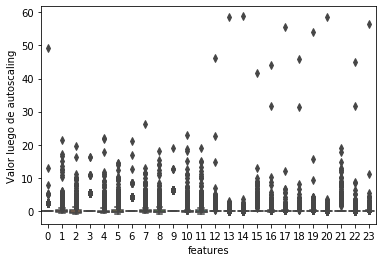

In [70]:
# visualizamos nuestros datos luego del autoscaling
sns.boxplot(data = pd.DataFrame(dfscal))
plt.xlabel("features")
plt.ylabel("Valor luego de autoscaling")
plt.show()

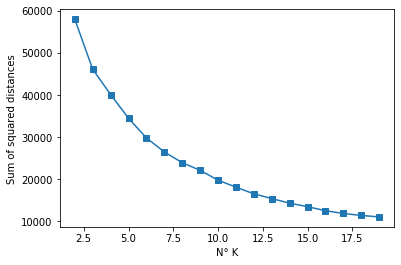

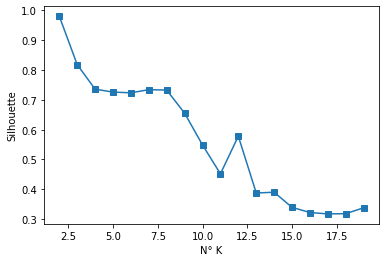

In [71]:
dist_cent = []
sill_list = []
for k in range(2, 20):
    kmeans = KMeans(n_clusters=k, random_state=3).fit(dfscal)
    sill_score = silhouette_score(dfscal,kmeans.labels_)
    sill_list.append(sill_score)
    dist_cent.append(kmeans.inertia_)
plt.plot(range(2, 20), dist_cent, marker='s');
plt.xlabel('N° K')
plt.ylabel('Sum of squared distances')
plt.show()
plt.plot(range(2, 20), sill_list, marker='s');
plt.xlabel('N° K')
plt.ylabel('Silhouette')
plt.show()

In [72]:
#El valor Silhouette para siete clusters es superior a 70%, lo cual entendemos como aceptable. 
#A su vez es el momento donde el codo se flexiona. 
# Guardamos las predicciones
kmeans = KMeans(n_clusters = 7, init = 'k-means++', random_state=42)
y_kmeans = kmeans.fit_predict(dfscal)
# Observamos ls etiquetas predichas por el modelo
print(y_kmeans)
print('Con 7 clusters obtenemos un score de ', silhouette_score(dfscal,kmeans.labels_), ' por lo que lo consideraremos como un buen resultado. Más que nada porque no encontramos un punte de quiebre superador con el método del codo')


[0 0 0 ... 0 0 0]
Con 7 clusters obtenemos un score de  0.7341607467075008  por lo que lo consideraremos como un buen resultado. Más que nada porque no encontramos un punte de quiebre superador con el método del codo


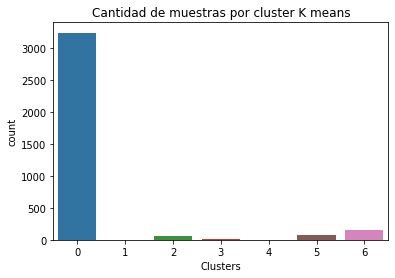

In [73]:
# Contamos cuantas muestras quedaron en cada cluster
sns.countplot(y_kmeans)
plt.title("Cantidad de muestras por cluster K means")
plt.xlabel("Clusters")
plt.show()


In [74]:
# Agregamos las etiquetas al dataframe
df['cluster'] = y_kmeans
df[['cluster']].head()


,cluster
Momento_delito_tipo,
RADIO_I,
10_10_1,0
10_10_10,0
10_10_11,0
10_10_12,0
10_10_2,0


### Replicaremos este análisis a nivel barrio

In [30]:
#Crear wide 
df = pd.read_csv ("D:/ClusterIA/TP/Delito con radio censal.csv",encoding='utf-8',sep=';',low_memory=False)
df = df.loc[df['franja_horaria'] != 'S/D']
df['subtipo_delito'] = df['subtipo_delito'].fillna('S/D')
df = df.loc[(df['subtipo_delito'] != 'Siniestro Vial')]

#Para diferenciar los delitos por momento del día dividimos la franja horaria según grupos, así identificar clusters que incluyan el momento del dia en que ocurrieron los delitos
df['franja_horaria'] = df['franja_horaria'].astype(int)
df['Momento_dia'] = 'Otro'
df.loc[df['franja_horaria'].between(0,5,inclusive=True),'Momento_dia'] = 'Madrugada'
df.loc[df['franja_horaria'].between(6,11,inclusive=True),'Momento_dia'] = 'Mañana'
df.loc[df['franja_horaria'].between(12,17,inclusive=True),'Momento_dia'] = 'Tarde'
df.loc[df['franja_horaria'].between(18,23,inclusive=True),'Momento_dia'] = 'Noche'
df = df.loc[df['RADIO_I'].notnull()]

#Agrupamos por barrio en vez de RADIO_I
T_cantidad = df.groupby(['barrio','Momento_dia','tipo_delito'], as_index=False).agg({"cantidad_registrada": "count"})

T_cantidad["Momento_delito_tipo"] = T_cantidad["Momento_dia"] +'_'+ T_cantidad["tipo_delito"]
T_cantidad['Momento_delito_tipo'] = T_cantidad['Momento_delito_tipo'].str.replace('\(','_')
T_cantidad['Momento_delito_tipo'] = T_cantidad['Momento_delito_tipo'].str.replace('\)','_')
T_cantidad['Momento_delito_tipo'] = T_cantidad['Momento_delito_tipo'].str.replace(' ','')
T_cantidad = T_cantidad[['barrio','Momento_delito_tipo','cantidad_registrada']]
T_cantidad

,barrio,Momento_delito_tipo,cantidad_registrada
0,Agronomía,Madrugada_Hurto_sinviolencia_,58
1,Agronomía,Madrugada_Robo_conviolencia_,118
2,Agronomía,Mañana_Hurto_sinviolencia_,136
3,Agronomía,Mañana_Robo_conviolencia_,193
4,Agronomía,Noche_Hurto_sinviolencia_,296
...,...,...,...
504,Vélez Sársfield,Mañana_Robo_conviolencia_,526
505,Vélez Sársfield,Noche_Hurto_sinviolencia_,796
506,Vélez Sársfield,Noche_Robo_conviolencia_,971
507,Vélez Sársfield,Tarde_Hurto_sinviolencia_,479


In [32]:
T_poblacion = df[['barrio','POBLACI']].drop_duplicates()
T_poblacion = T_poblacion.groupby(['barrio'], as_index=False).agg({"POBLACI": "sum"})
T_conjunta = pd.merge(T_cantidad, T_poblacion,how='left', on='barrio')
T_conjunta = T_conjunta.loc[T_conjunta['barrio'] != 0]
T_conjunta['cantidad_registrada'] = T_conjunta['cantidad_registrada'].fillna(0)
T_conjunta['del_10000_hab'] = (T_conjunta['cantidad_registrada'] / T_conjunta['POBLACI'])*10000
T_conjunta = T_conjunta[['barrio','Momento_delito_tipo','cantidad_registrada','del_10000_hab']]
T_conjunta = T_conjunta.pivot_table(index=['barrio'],values=['cantidad_registrada','del_10000_hab'],columns=['Momento_delito_tipo'])
T_conjunta = T_conjunta.fillna(0)
df_barrio = T_conjunta

In [35]:
# Realizamos un autoscaling con los datos, para todas las features
scaler = preprocessing.StandardScaler().fit(df_barrio)
# nuestros datos pre-procesados los guardamos en "xscal"
df_barrio_scal = scaler.transform(df_barrio)  
df_barrio_scal = pd.DataFrame(df_barrio_scal)
df_barrio_scal.head()

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,-0.563602,-0.808039,-0.997740,-0.770172,-0.950402,-1.080679,-0.637419,-0.952626,-1.016337,-0.746830,...,-1.035905,-0.856352,-0.538907,-0.911945,-0.869201,-0.521952,-1.075409,-0.905214,-0.479994,-0.798660
1,-0.563602,0.910700,1.238714,0.008107,0.737224,1.269062,-0.206488,1.079787,1.834364,-0.287242,...,0.209812,-0.418743,-0.209427,0.038917,-0.547943,-0.088754,0.881876,-0.589459,-0.161180,0.147392
2,1.127204,1.359857,2.367742,0.786386,2.820804,2.667934,1.301771,2.129760,2.534762,1.091521,...,1.116805,-0.016665,0.780610,1.016665,0.517772,0.560459,1.514499,0.306530,1.518337,1.591886
3,1.502938,0.373270,1.054383,3.121223,0.332372,0.907915,3.025495,-0.036791,0.649027,0.631933,...,0.700097,2.037773,-0.171221,0.316781,2.742686,-0.609331,0.215922,0.347731,-0.326137,0.255669
4,-0.187867,0.188934,0.026162,-0.770172,0.820271,0.331908,0.008978,0.941024,0.823973,-0.287242,...,-0.830540,-0.856352,-0.096756,-0.612611,-0.354155,-0.081377,-0.122137,-0.567732,0.080732,-0.045569


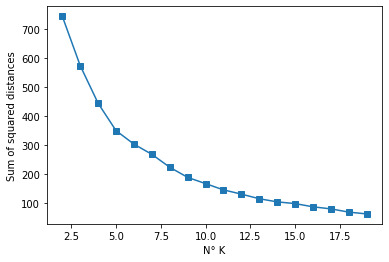

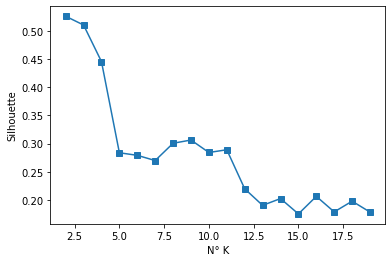

In [57]:
dist_cent = []
sill_list = []
for k in range(2, 20):
    kmeans = KMeans(n_clusters=k, random_state=10).fit(df_barrio_scal)
    sill_score = silhouette_score(df_barrio_scal,kmeans.labels_)
    sill_list.append(sill_score)
    dist_cent.append(kmeans.inertia_)
plt.plot(range(2, 20), dist_cent, marker='s');
plt.xlabel('N° K')
plt.ylabel('Sum of squared distances')
plt.show()
plt.plot(range(2, 20), sill_list, marker='s');
plt.xlabel('N° K')
plt.ylabel('Silhouette')
plt.show()

Pese a no obtener buenos valores de silhouette procederemos a escoger el análisis de tres clusters, de forma de lograr cierta comparabilidad con el ejercicio anterior. 



In [58]:
# Guardamos las predicciones
kmeans = KMeans(n_clusters = 3, init = 'k-means++', random_state=10)
y_kmeans_2 = kmeans.fit_predict(df_barrio_scal)
# Observamos ls etiquetas predichas por el modelo
print(y_kmeans_2)
print('Con 3 clusters obtenemos un score de ', silhouette_score(df_barrio_scal,kmeans.labels_), ' por lo que lo consideraremos como un buen resultado. Más que nada porque no encontramos un punte de quiebre superador con el método del codo')


[1 1 2 2 1 1 1 1 1 1 1 2 2 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 2 1 1 0 1 1 1 1 1
 2 1 1 1 1 1 1 1 1 1 1]
Con 7 clusters obtenemos un score de  0.5100511370210171  por lo que lo consideraremos como un buen resultado. Más que nada porque no encontramos un punte de quiebre superador con el método del codo


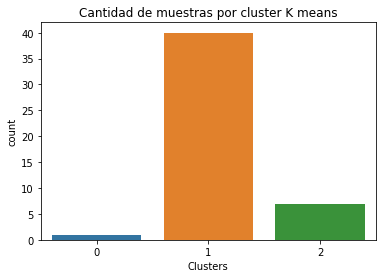

In [59]:
# Contamos cuantas muestras quedaron en cada cluster
sns.countplot(y_kmeans_2)
plt.title("Cantidad de muestras por cluster K means")
plt.xlabel("Clusters")
plt.show()

In [61]:
# Agregamos las etiquetas al dataframe
df_barrio['cluster'] = y_kmeans_2
df_barrio[['cluster']].head()


,cluster
tipo_delito,
barrio,
Agronomía,1
Almagro,1
Balvanera,2
Barracas,2
Belgrano,1


In [76]:
#Descargaremos los dos dataframes creados (con radio censal y por barrio) para generar mapas mediante QGIS
df[['cluster']].to_csv(r'D:/ClusterIA/TP/kmeans_radio.csv')
df_barrio[['cluster']].to_csv(r'D:/ClusterIA/TP/kmeans_barrio.csv')

### Regresión
Por último haremos un ejercicio de regresión para analizar si la cantidad de población explica la cantidad de delitos por barrio.

In [77]:
delitos_2016 = pd.read_csv ("D:/ClusterIA/TP/datasets/delitos_2016.csv")
delitos_2017 = pd.read_csv ("D:/ClusterIA/TP/datasets/delitos_2017.csv")
delitos_2018 = pd.read_csv ("D:/ClusterIA/TP/datasets/delitos_2018.csv")
delitos_2019 = pd.read_csv ("D:/ClusterIA/TP/datasets/delitos_2019.csv")
delitos = pd.concat([delitos_2016, delitos_2017, delitos_2018, delitos_2019], axis=0)

delitos= delitos.drop(['id'], axis=1)
delitos['cantidad_delitos'] = delitos['cantidad_registrada'].astype(int)
delitos['anio']= delitos['fecha'].str[:4]
delitos['mes']= delitos['fecha'].str[5:7]
delitos['dia']= delitos['fecha'].str[8:10]
delitos['periodo']= delitos['anio']+delitos['mes']

delitos['fecha'] = pd.to_datetime(delitos['fecha'])
delitos['dia_semana'] = delitos['fecha'].dt.day_name()
delitos['barrio2']= delitos['barrio'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
delitos['barrio2']= delitos['barrio2'].str.upper()

In [78]:
# Realizamos una pivot table para visualizar los delitos por barrio
delitos_pivot_barrio = pd.pivot_table(delitos,values = 'cantidad_delitos', index = delitos.barrio2.values, aggfunc = np.sum)
delitos_pivot_barrio = delitos_pivot_barrio.sort_values('cantidad_delitos', ascending=False)
delitos_pivot_barrio.head()

,cantidad_delitos
PALERMO,38338
BALVANERA,33749
FLORES,24904
SAN NICOLAS,23411
RECOLETA,22565


In [79]:
# Importamos dataset de población por barrio
poblacion = pd.read_csv('D:/ClusterIA/TP/datasets/caba_pob_barrios_2010.csv')
# Normalizamos para convertir la ñ en n
poblacion['BARRIO']= poblacion['BARRIO'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')

poblacion = poblacion.set_index('BARRIO')
poblacion.head()




,POBLACION
BARRIO,
AGRONOMIA,13912
ALMAGRO,131699
BALVANERA,138926
BARRACAS,89452
BELGRANO,126267


In [80]:
# Hacemos el join de cantidad de delitos y población por barrio
poblacion_delitos = poblacion.join(delitos_pivot_barrio)
poblacion_delitos.head()



,POBLACION,cantidad_delitos
BARRIO,,
AGRONOMIA,13912,1897
ALMAGRO,131699,19869
BALVANERA,138926,33749
BARRACAS,89452,14132
BELGRANO,126267,16027


In [81]:
# Agregamos una columna para ver la incidencia de delitos por barrio: delitos/población
poblacion_delitos['delitos/poblacion']= poblacion_delitos['cantidad_delitos']/poblacion_delitos['POBLACION']
poblacion_delitos.head()



,POBLACION,cantidad_delitos,delitos/poblacion
BARRIO,,,
AGRONOMIA,13912,1897,0.136357
ALMAGRO,131699,19869,0.150867
BALVANERA,138926,33749,0.242928
BARRACAS,89452,14132,0.157984
BELGRANO,126267,16027,0.126929


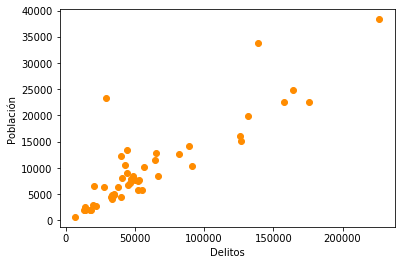

In [82]:
# Vemos si existe una correlación entre cantidad de delitos y población
# Visualizamos los datos en un scatterplot
plt.scatter(poblacion_delitos['POBLACION'],poblacion_delitos['cantidad_delitos'],color="darkorange")
plt.xlabel('Delitos')
plt.ylabel('Población')
plt.show()

### Obtenemos percentiles para detectar outliers

Obtenemos los percentiles 1 y 99 de delitos y población para filtrar outliers de estas features

In [83]:
cantidad_delitos_q99 = poblacion_delitos.cantidad_delitos.quantile(0.99)
print("el cuantil 0.99 de la feature 'cantidad_delitos' es = " + str(cantidad_delitos_q99))

el cuantil 0.99 de la feature 'cantidad_delitos' es = 36181.170000000006


In [84]:
cantidad_delitos_q01 = poblacion_delitos.cantidad_delitos.quantile(0.01)
print("el cuantil 0.01 de la feature 'cantidad_delitos' es = " + str(cantidad_delitos_q01))

el cuantil 0.01 de la feature 'cantidad_delitos' es = 1239.8000000000002


In [85]:
# Creamos una nueva tabla excluyendo los outliers
poblacion_delitos_filt = poblacion_delitos.loc[(poblacion_delitos.cantidad_delitos < cantidad_delitos_q99) & (poblacion_delitos.cantidad_delitos > cantidad_delitos_q01)]

In [89]:
### Creamos variable dependiente
y = np.array(poblacion_delitos_filt[["cantidad_delitos"]])
#Creamos variable independiente
x = np.array(poblacion_delitos_filt[["POBLACION"]])
### Dividimos el dataset en Train y Test
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.85, random_state=42)

#Creamos un modelo de Regresión Lineal
# Creamos un modelo generico de regresion lineal
lr = LinearRegression()
# Ajustamos el modelo de regresion lineal utilizando el set de train (no escalamos ya que utilizamos una sola x)
lr.fit(xtrain, ytrain)
# Obtenemos las predicciones que realiza el modelo con las muestras de test
# las predicciones las guardamos en "ypred"
ypred = lr.predict(xtest)# Calculamos R2 y medidas de error

# Calculamos la metricas para LR
MSE = mean_squared_error(ytest, ypred)
MAE = mean_absolute_error(ytest, ypred)
R2 = r2 = r2_score(ytest, ypred)

print(MSE)
print(MAE)
print(R2)

18886876.22940463
2571.6380722384447
0.6253217376430916


In [90]:
# Creamos un dataframe para guardar los resultados
results_df = pd.DataFrame(columns=['Model','R2','MSE','MAE'])
#Guardamos los resultados
results_df = results_df.append({'Model':'Linear Regression',
                                'R2':R2,
                                'MSE':MSE,
                                'MAE':MAE},ignore_index=True)

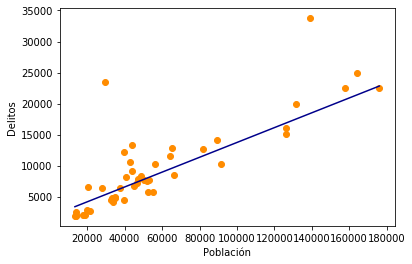

In [91]:
# Visualizamos los datos con la linea de regresión
X = np.arange(min(x), max(x), 0.1)
X = X.reshape((len(X), 1))
plt.scatter(x,y,color="darkorange", label ="data")
plt.plot(X, lr.predict(X), color = "darkblue")
plt.xlabel('Población')
plt.ylabel('Delitos')
plt.show()